# Community Detection (Unsupervised Learning)

This notebook demonstrates **community detection** on graph data using the `rice_ml` package.

**Goal:** given an **adjacency matrix** `A` for an undirected graph, assign each node a **community label**.

Notes:
- The `rice_ml` implementation is lightweight.
- We keep the code reproducible (fixed random seed where relevant).


In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import os, sys

# Add src/ to path so we can import rice_ml when running the notebook directly
# (Notebook path: examples/Unsupervised_Learning/Community_Detection/)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../../src')))

from rice_ml.unsupervised_learning.community_detection import CommunityDetection

np.random.seed(42)


## 1. Graph Data: Adjacency Matrices

For a graph with `n` nodes, the **adjacency matrix** `A` has shape `(n, n)`.

- `A[i, j] = 1` means there is an edge between nodes `i` and `j`.
- For undirected graphs, `A` is symmetric: `A[i, j] = A[j, i]`.
- We assume **no self-loops**: `A[i, i] = 0`.


In [8]:
def adjacency_from_edges(n_nodes, edges):
    """Build an undirected adjacency matrix from an edge list."""
    A = np.zeros((n_nodes, n_nodes), dtype=float)
    for i, j in edges:
        A[i, j] = 1.0
        A[j, i] = 1.0
    np.fill_diagonal(A, 0.0)
    return A

def print_basic_graph_stats(A, name="Graph"):
    A = np.asarray(A)
    if A.ndim != 2 or A.shape[0] != A.shape[1]:
        raise ValueError("Adjacency matrix must be square (n, n).")

    n = A.shape[0]

    # edge count = number of nonzero entries in upper triangle (excluding diagonal)
    nonzero_edges = int(np.count_nonzero(np.triu(A, 1)))

    # if weighted, total weight is sum of upper triangle weights
    total_weight = float(np.sum(np.triu(A, 1)))

    degrees_unweighted = (A > 0).sum(axis=1).astype(int)

    print(f"{name}: n_nodes={n}, n_edges(nonzero)={nonzero_edges}, total_edge_weight={total_weight:.1f}")
    print(f"  degree(min/mean/max, unweighted) = {degrees_unweighted.min()} / {degrees_unweighted.mean():.2f} / {degrees_unweighted.max()}")



## 2. A Toy Example (Easy to Verify)

We start with a toy graph that has **three obvious groups** (three connected components).  
A simple community detector should clearly separate them.


Toy graph: n_nodes=10, n_edges(nonzero)=9, total_edge_weight=9.0
  degree(min/mean/max, unweighted) = 1 / 1.80 / 2


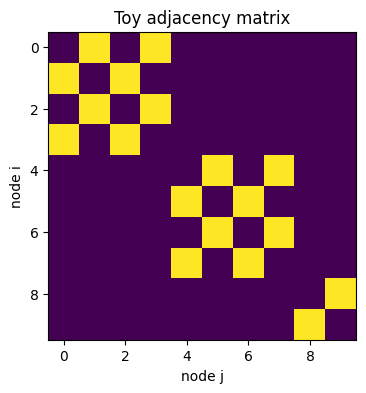

In [9]:
# Toy graph: 3 components
# Component 0: nodes 0-3
# Component 1: nodes 4-7
# Component 2: nodes 8-9
toy_edges = [
    (0, 1), (1, 2), (2, 3), (0, 3),
    (4, 5), (5, 6), (6, 7), (4, 7),
    (8, 9)
]
A_toy = adjacency_from_edges(10, toy_edges)
print_basic_graph_stats(A_toy, name="Toy graph")

plt.figure(figsize=(4, 4))
plt.imshow(A_toy, aspect="equal")
plt.title("Toy adjacency matrix")
plt.xlabel("node j")
plt.ylabel("node i")
plt.show()


## 3. Fit Community Detection on the Toy Graph

We call:
- `fit_predict(A)` → returns an integer label per node.

Then we check:
- how many communities were found,
- how many nodes are in each community.


In [10]:
model = CommunityDetection()
labels_toy = model.fit_predict(A_toy)

print("Toy labels:", labels_toy)
unique, counts = np.unique(labels_toy, return_counts=True)
print("Communities found:", len(unique))
print("Community sizes:", dict(zip(unique.tolist(), counts.tolist())))


Toy labels: [0 0 0 0 1 1 1 1 2 2]
Communities found: 3
Community sizes: {0: 4, 1: 4, 2: 2}


## 4. A Real Dataset (Optional): Zachary’s Karate Club

Zachary’s Karate Club is a classic small social network (34 nodes).

We try to load it with `networkx`:
- If `networkx` is installed, we can also draw the graph.
- If it is not installed, the notebook will still run (we’ll use a fallback edge list).


Karate Club: n_nodes=34, n_edges(nonzero)=78, total_edge_weight=78.0
  degree(min/mean/max, unweighted) = 1 / 4.59 / 17


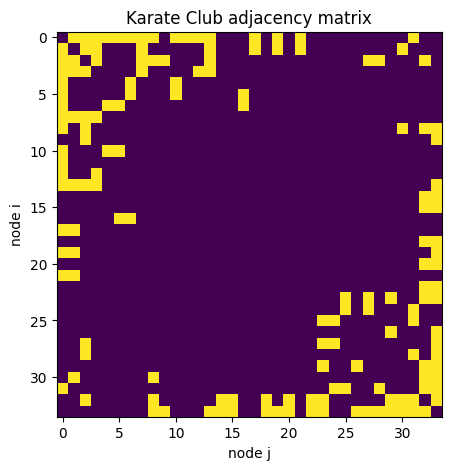

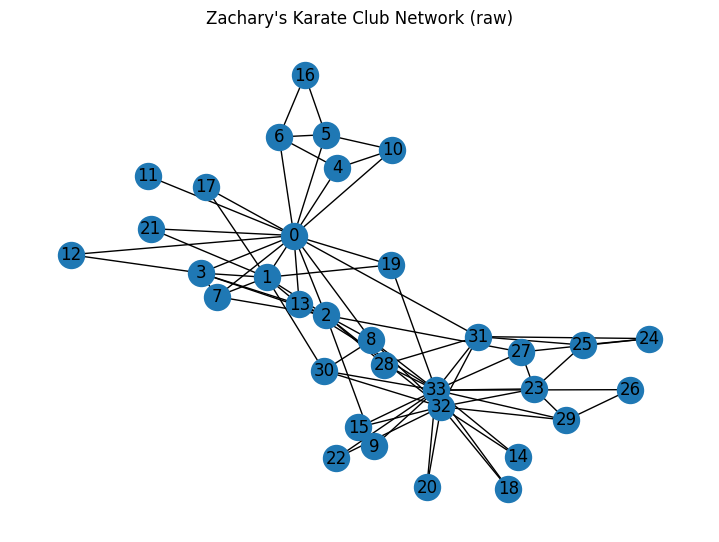

In [ ]:
# Attempt to load Karate Club via networkx
have_nx = False
try:
    import networkx as nx
    have_nx = True
except ImportError:
    nx = None
    have_nx = False

if have_nx:
    G = nx.karate_club_graph()
    A_karate_w = nx.to_numpy_array(G, dtype=float)
    A_karate = (A_karate_w > 0).astype(float)   
    print_basic_graph_stats(A_karate, name="Karate Club")
else:
    # Fallback: build adjacency from a known edge list (Karate Club has 34 nodes, 78 edges)
    karate_edges = [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (0, 13), (0, 17), (0, 19), (0, 21), (0, 31), (1, 2), (1, 3), (1, 7), (1, 13), (1, 17), (1, 19), (1, 21), (1, 30), (2, 3), (2, 7), (2, 8), (2, 9), (2, 13), (2, 27), (2, 28), (2, 32), (3, 7), (3, 12), (3, 13), (4, 6), (4, 10), (5, 6), (5, 10), (5, 16), (6, 16), (8, 30), (8, 32), (8, 33), (9, 33), (13, 33), (14, 32), (14, 33), (15, 32), (15, 33), (18, 32), (18, 33), (19, 33), (20, 32), (20, 33), (22, 32), (22, 33), (23, 25), (23, 27), (23, 29), (23, 32), (23, 33), (24, 25), (24, 27), (24, 31), (25, 31), (26, 29), (26, 33), (27, 33), (28, 31), (28, 33), (29, 32), (29, 33), (30, 32), (30, 33), (31, 32), (31, 33), (32, 33)]
    A_karate = adjacency_from_edges(34, karate_edges)
    print_basic_graph_stats(A_karate, name="Karate Club (fallback)")

# Visualize adjacency matrix (works with or without networkx)
plt.figure(figsize=(5, 5))
plt.imshow(A_karate, aspect="equal")
plt.title("Karate Club adjacency matrix")
plt.xlabel("node j")
plt.ylabel("node i")
plt.show()

# Optional: draw the network if networkx is available
if have_nx:
    plt.figure(figsize=(7, 5))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos=pos, with_labels=True, node_size=350)
    plt.title("Zachary's Karate Club Network (raw)")
    plt.show()


## 5. Fit Community Detection on Karate Club

Depending on the specific community detection strategy implemented in `rice_ml`,
you may see:
- **one** community (if the method is “connected components” on a connected graph), or
- **multiple** communities (if the method can split a connected graph into subgroups).

Either outcome is useful for learning:
- “Connected components” is easy and fast, but cannot discover internal structure.
- More advanced methods (e.g., label propagation, spectral methods, modularity-based) can split connected graphs.


In [6]:
model2 = CommunityDetection()
labels_karate = model2.fit_predict(A_karate)

unique, counts = np.unique(labels_karate, return_counts=True)
print("Communities found:", len(unique))
print("Community sizes:", dict(zip(unique.tolist(), counts.tolist())))
print("First 20 labels:", labels_karate[:20])


Communities found: 1
Community sizes: {0: 34}
First 20 labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## 6. Visualize Communities (Karate Club)

We color nodes by the detected label.


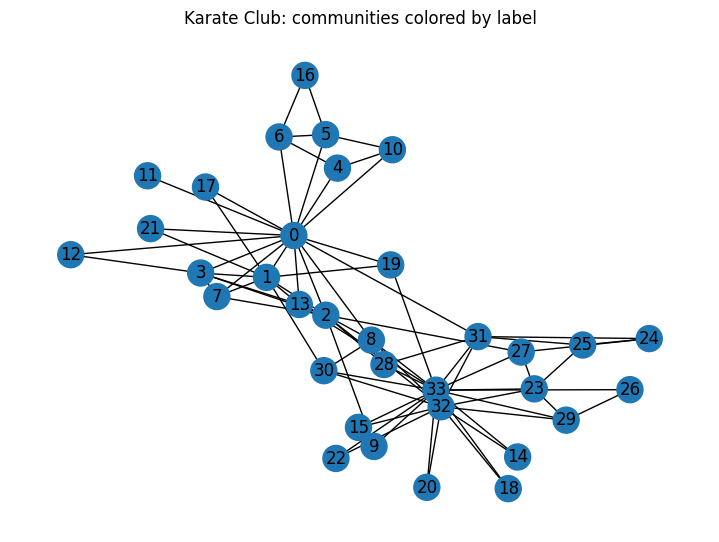

In [12]:
if have_nx:
    labs = labels_karate
    denom = max(1, int(labs.max() - labs.min()))
    color_vals = (labs - labs.min()) / denom
    colors = plt.cm.tab20(color_vals)

    plt.figure(figsize=(7, 5))
    nx.draw(G, pos=pos, with_labels=True, node_color=colors, node_size=350)
    plt.title("Karate Club: communities colored by label")
    plt.show()

## 7. Interpretation

- **Toy graph:** the algorithm correctly recovers the **three disconnected components** as three communities.
  In our run we obtained **3** labels with sizes **{0: 4, 1: 4, 2: 2}**, which matches how we constructed the toy graph.

- **Karate Club:** the Zachary Karate Club network is **connected**, so a connected-components-based community detector will return **one** community.
  In our run we obtained **1** label with size **{0: 34}**. Because every node has the same label, the “colored by label” plot looks essentially the same as the raw network plot.

**Possible improvements:**
- Implement a community detection method that can split a connected graph into sub-communities (e.g., label propagation, spectral clustering on the graph Laplacian, or modularity-based methods).
- Add an internal quality measure (e.g., modularity) to compare different partitions.
- Add optional hyperparameters such as `n_communities` (if the chosen method supports it).

